In [3]:
from pydub import AudioSegment
import os

## Split MP3 file into equal-size file

In [4]:
from pydub import AudioSegment
import os

def splitMP3():
    locals_list = ['01', '05', '07', '12', '13', '20', '28', '32', '57', '59']  # List of localities to process
    locals_num_of_samples = [40 , 44, 52, 50, 70, 41, 70, 70, 70, 55] # Number of samples for each locality

    for index, local in enumerate(locals_list):
        cnt = 0  # Initialize counter for each locality

        # Loop through the number of samples for each locality
        for i in range(1, locals_num_of_samples[index] + 1):
            mp3_file_path = 'dataset_raw/{}/speech{}{:0>4}.mp3'.format(local, local, i)
            #Check existed
            if not os.path.exists(mp3_file_path):
                continue  

            audio = AudioSegment.from_mp3(mp3_file_path)

            length = len(audio)
            length_segment = 8e3
            num_segment = len(audio) // length_segment
            if length - length_segment*num_segment > 5e3:
                num_segment += 1

            for j in range(int(num_segment)): 
                start_time = j * length_segment
                end_time = (j + 1) * length_segment # Sử dụng (j + 1) để chia đúng các phần
                # Determine the number of segments needed and check for the last segment
                if j == int(num_segment) - 1: 
                    end_time = length

                sliced_audio = audio[start_time:end_time]
                
                cnt += 1
                output_file = 'dataset/speech{}{:0>4}.wav'.format(local, cnt)
                sliced_audio.export(output_file, format="wav")


# Gọi hàm để chia tệp MP3
splitMP3()


## Preprocessing

### Loading file
Có thể dùng nhiều thư viện:
- librosa
- scipy
- torchaudio

In [8]:
import librosa

In [16]:
AUDIO_PATH = 'dataset/speech010001.wav'
samples, sample_rate = librosa.load(AUDIO_PATH, sr = None)
print('samples: \n', samples)  # as a numpy.ndarray
print('sample_shape: ', samples.shape) #384000 = 48000*8 (8s)
print('sample_rate: ', sample_rate) # 48000


samples: 
 [0.01327515 0.02130127 0.02429199 ... 0.00566101 0.00582886 0.00650024]
sample_shape:  (384000,)
sample_rate:  48000


### Display

In [11]:
import matplotlib.pyplot as plt

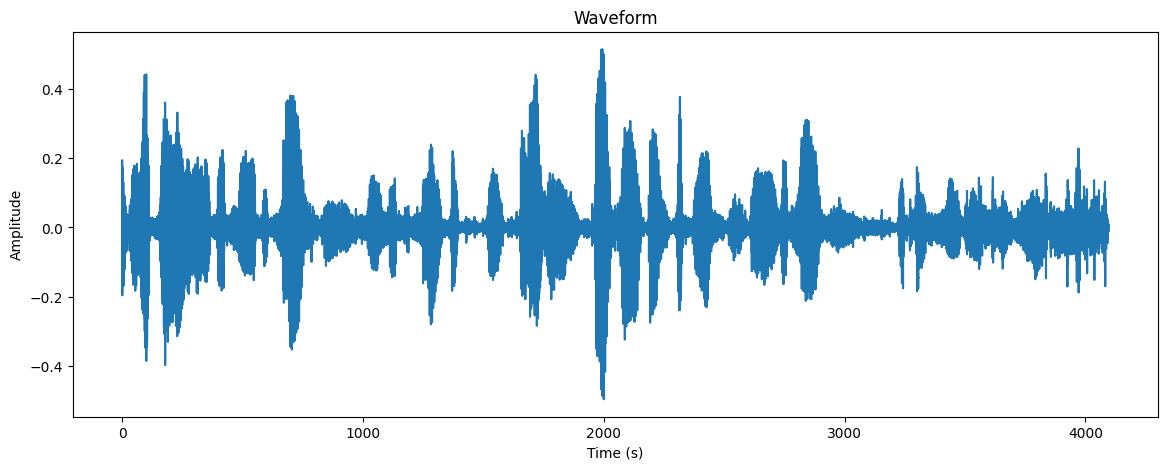

In [17]:
time = librosa.times_like(samples, sr=sample_rate)
plt.figure(figsize=(14, 5))
plt.plot(time, samples)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

### Fast Fourier Transform - FFT
Chuyển từ miền thời gian sang miền tần số. Nhưng điều này làm mất thông tin về thời gian

### Spectrogram
Biểu diễn trực quan các tần số của một tín hiệu nhất định với thời gian.
- Ý tưởng chính là chia tín hiệu âm thanh thành các khung nhỏ hơn (cửa sổ) và tính toán DFT (hoặc FFT) cho mỗi cửa sổ đó. Bằng cách này, chúng tôi sẽ nhận được tần số cho mỗi cửa sổ và số cửa sổ sẽ đại diện cho thời gian. Để không làm mất một vài tần số khi lấy các cửa sổ một cách liên tục, chúng ta thường giữ cho các cửa sổ này chồng lên nhau (overlap). Đối với tác vụ nhận dạng giọng nói thông thường, bạn nên sử dụng cửa sổ dài từ 20 đến 30 ms. Một con người không thể nói nhiều hơn một âm vị trong khoảng thời gian này.
- Đầu ra của thuật toán DFT (hoặc FFT) là 1 mảng các số đại diện cho các biên độ của các tần số khác nhau trong cửa sổ

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_18508\869377354.py:2: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(spectrogram)


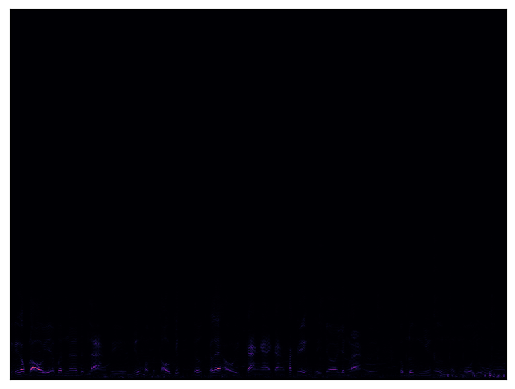

In [18]:
spectrogram = librosa.stft(samples)
librosa.display.specshow(spectrogram)


Nhìn vào biểu đồ trên, chúng ta không thể thấy rõ được các thông tin về tần số, biên độ mà Spectrogram thể hiện. Điều này được giải thích là do khả năng nhận thức âm thanh của con người. Hầu hết những âm thanh mà chúng ta nghe được đều tập trung xung quanh một dải tần số và biên độ khá hẹp. <br>
 Vì vậy, trong nhiều bài toán (đặc biệt là nhận dạng giọng nói), Spectrogram không phải là sự lựa chọn hoàn hảo.<br>
Vì vậy ta cần thêm vài bước tính nữa để thu được dạng MFCC hoặc Mel Spectrogram, tốt hơn, phổ biến hơn, hiệu quả hơn Spectrogram.

### **Mel Spectrogram**
- Sự chuyển đổi từ thang đo Hertz sang thang đo Mel <br>
$m = 1127 . \log{(1 + \frac{f}{700})}$
#### ***Mel Scale***
Tần số (trục y) được thay thế bằng giá trị Logarithmic của nó
#### ***Decibel  Scale***
Biên độ được thay thế bằng giá trị Logarithmic của nó

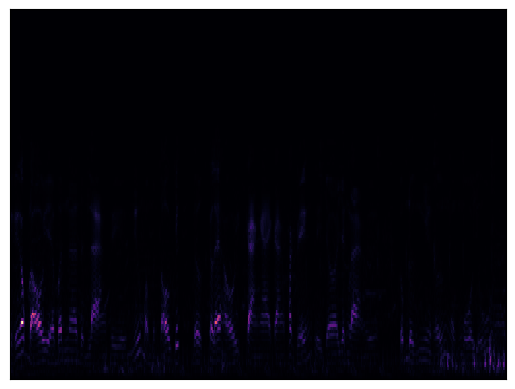

In [19]:
#Nếu chỉ sử dụng Mel Scale
spectrogram_mag, _ = librosa.magphase(spectrogram)
mel_scale_spectrogram = librosa.feature.melspectrogram(S = spectrogram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_spectrogram)

Biểu đồ này biểu diễn tốt hơn Spectrograms, nhưng phần lớn vẫn còn tối và không mang đủ thông tin hữu ích.

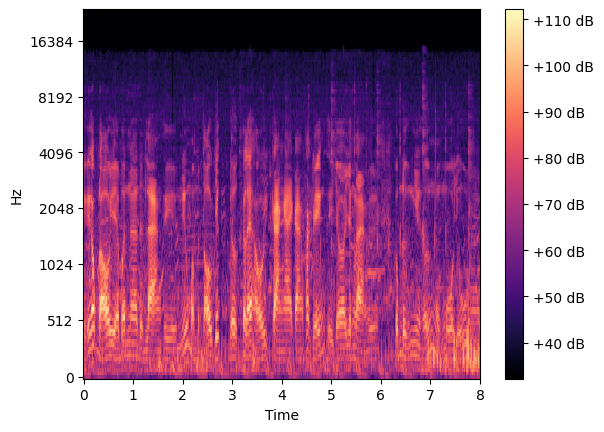

In [22]:
import numpy as np
# Sử dụng thêm Decibel Scale
mel_spectrogram = librosa.amplitude_to_db(mel_scale_spectrogram, ref = np.min)
librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format = '%+2.0f dB')


# Audio Normalization

In [24]:
import soundfile as sf #for write .wav

def peak_normalization(samples):
    # Find the maximum amplitude value in the samples
    max_amplitude = np.max(np.abs(samples))
    
    # Normalize the samples by dividing each sample by the maximum amplitude
    normalized_samples = samples / max_amplitude
    
    return normalized_samples

def rms_normalization(samples):
    # Calculate the root mean square (RMS) value of the samples
    rms_value = np.sqrt(np.mean(np.square(samples)))
    
    # Normalize the samples by dividing each sample by the RMS value
    normalized_samples = samples / rms_value
    
    return normalized_samples

# Peak normalization
peak_normalized_audio = librosa.util.normalize(samples, norm=+1)

# RMS normalization
rms_normalized_audio = librosa.util.normalize(samples, norm=None)
# write data after Normalization
sf.write("dataset/peak_normalized_audio.wav", peak_normalized_audio, sample_rate)
sf.write("dataset/rms_normalized_audio.wav", rms_normalized_audio, sample_rate)